**Import all the necessary libraries.**

In [ ]:
import os
import torch
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.patches as patches

**Visualize the images in training directory with corresponding labels. Also, check the size of the images.**

(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)


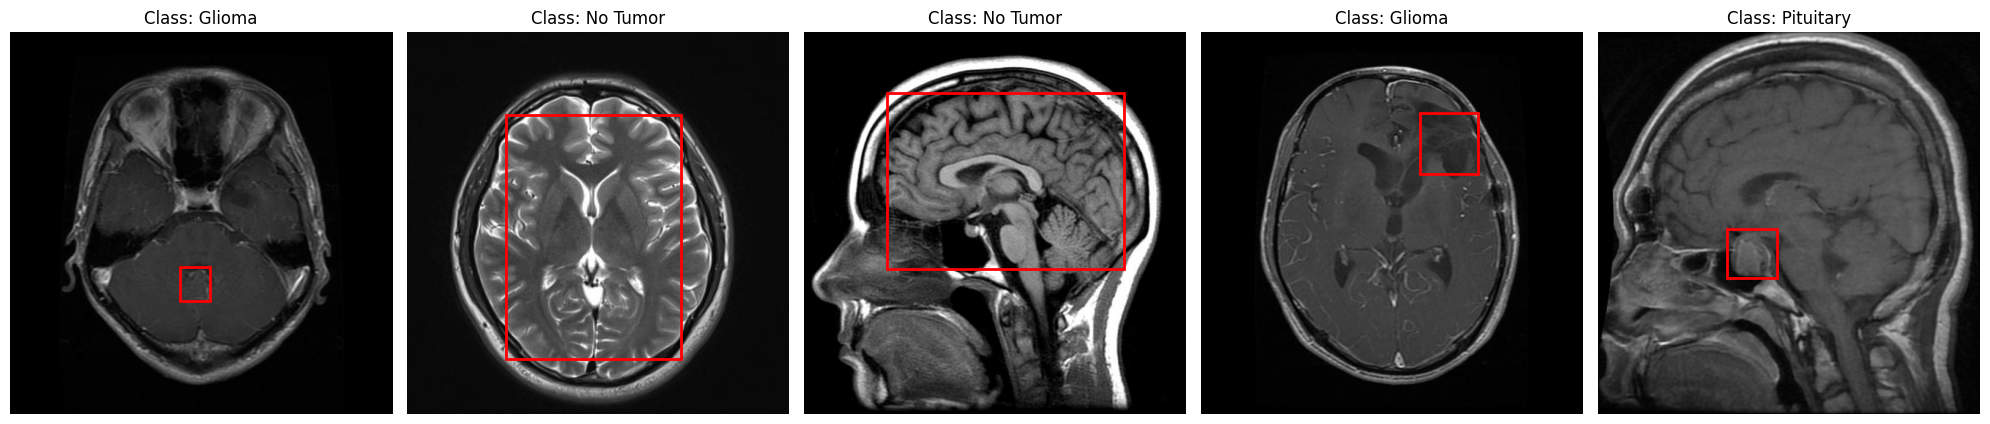

In [ ]:
# Directory paths
image_dir = '/kaggle/input/customcnn-tumor/Labeled MRI Brain Tumor Dataset/train/images'
label_dir = '/kaggle/input/customcnn-tumor/Labeled MRI Brain Tumor Dataset/train/labels'

# Class names (extend if necessary)
class_names = {0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}

# Function to visualize an image with its bounding box
def visualize_image_with_label_horizontal(image_label_pairs):
    # Set up the horizontal layout
    plt.figure(figsize=(20, 10))

    for i, (image_path, label_path) in enumerate(image_label_pairs):
        # Load image
        image = Image.open(image_path).convert('RGB')
        img_width, img_height = image.size
        print(image.size)
        # Read label file
        with open(label_path, 'r') as f:
            label_data = f.read().strip().split()

        # Parse label
        class_id = int(label_data[0])  # First value is the class ID


        bbox = [float(x) for x in label_data[1:]]  # Remaining values are bounding box coordinates



        # Denormalize bounding box to pixel values
        x_center, y_center, box_width, box_height = bbox
        x_center *= img_width
        y_center *= img_height
        box_width *= img_width
        box_height *= img_height

        x1 = x_center - box_width / 2
        y1 = y_center - box_height / 2
        x2 = x_center + box_width / 2
        y2 = y_center + box_height / 2


        # Add subplot for the current image
        plt.subplot(1, len(image_label_pairs), i + 1)
        plt.imshow(image)
        plt.gca().add_patch(plt.Rectangle((x1, y1), box_width, box_height, edgecolor='r', facecolor='none', lw=2))
        plt.title(f"Class: {class_names[class_id]}")
        plt.axis('off')  # Turn off axis for cleaner visualization

    plt.tight_layout()
    plt.show()

# Filter image-label pairs
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

# Ensure alignment by matching names
image_label_pairs = [
    (os.path.join(image_dir, img), os.path.join(label_dir, lbl))
    for img, lbl in zip(image_files, label_files)
    if os.path.splitext(img)[0] == os.path.splitext(lbl)[0]
]

# Randomly select 5 samples
selected_pairs = random.sample(image_label_pairs, min(5, len(image_label_pairs)))

# Visualize selected images horizontally
visualize_image_with_label_horizontal(selected_pairs)


**Create a CustomImageDataset to retreive the necessary data for training. Also, convert the center co-ordinates to four cornors and normalize them for stable training.**

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images.
            annotation_dir (str): Directory containing the txt annotation files.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)  # Get all image file names in the directory

    def __len__(self):
        return len(self.image_names)  # Return the number of images

    def __getitem__(self, idx):
        # Load the image directly using the full path
        image = Image.open(os.path.join(self.image_dir, self.image_names[idx]))

        # Get the annotation path by replacing image extension with .txt
        annotation_path = os.path.join(self.annotation_dir, self.image_names[idx].replace('.jpg', '.txt'))

        # Read the annotation from the corresponding txt file
        with open(annotation_path, 'r') as file:
            # Assuming the format is: class_id cx cy h w (all normalized)
            line = file.readline().strip().split()
            class_id = int(line[0])  # Class ID
            cx = float(line[1])  # Center x (normalized)
            cy = float(line[2])  # Center y (normalized)
            h = float(line[3])  # Height (normalized)
            w = float(line[4])  # Width (normalized)


        # Convert center coordinates (cx, cy) and width/height (w, h) to bounding box corners
        xmin = (cx - w / 2) * w
        ymin = (cy - h / 2) * h
        xmax = (cx + w / 2) * w
        ymax = (cy + h / 2) * h

          # Normalize the bounding box coordinates by the image width and height
        xmin_normalized = xmin / w
        ymin_normalized = ymin / h
        xmax_normalized = xmax / w
        ymax_normalized = ymax / h

    # Convert the normalized bounding box to a tensor
        bbox = torch.tensor([xmin_normalized, ymin_normalized, xmax_normalized, ymax_normalized], dtype=torch.float32)

    # Apply any transformations to the image if provided
        if transform:
            image = transform(image)

    # Return the image, class_id (label), and normalized bounding box
        return image, class_id, bbox



**Create DataLoader for efficient training by batch processing and shuffling for better generalisation. Also, resize, convert to tensor and normalize the image.**

In [ ]:
# Define transformations for the datasets
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images to 256x256
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Training dataset
train_dataset = CustomImageDataset(
    image_dir='/kaggle/input/customcnn-tumor/Labeled MRI Brain Tumor Dataset/train/images',   # Path to training images
    annotation_dir='/kaggle/input/customcnn-tumor/Labeled MRI Brain Tumor Dataset/train/labels',  # Path to training annotations
    transform=transform
)

# Validation dataset
val_dataset = CustomImageDataset(
    image_dir='/kaggle/input/customcnn-tumor/Labeled MRI Brain Tumor Dataset/valid/images',   # Path to validation images
    annotation_dir='/kaggle/input/customcnn-tumor/Labeled MRI Brain Tumor Dataset/valid/labels',  # Path to validation annotations
    transform=transform
)

# Test dataset
test_dataset = CustomImageDataset(
    image_dir='/kaggle/input/customcnn-tumor/Labeled MRI Brain Tumor Dataset/test/images',   # Path to test images
    annotation_dir='/kaggle/input/customcnn-tumor/Labeled MRI Brain Tumor Dataset/test/labels',  # Path to test annotations
    transform=transform
)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,            # Training dataset
    batch_size=64,            # Batch size for training
    shuffle=True,             # Shuffle the training data
    num_workers=0             # Number of parallel workers to load the data
)

val_dataloader = DataLoader(
    val_dataset,              # Validation dataset
    batch_size=64,            # Batch size for validation
    shuffle=False,            # No need to shuffle validation data
    num_workers=0             # Number of parallel workers to load the data
)

test_dataloader = DataLoader(
    test_dataset,             # Test dataset
    batch_size=64,            # Batch size for testing
    shuffle=False,            # No need to shuffle test data
    num_workers=0             # Number of parallel workers to load the data
)


**Check the shape of the input to ensure it is acceptable for the model.**

In [ ]:
# Example of iterating through the DataLoader to get one image and one bounding box
for images, class_ids, bboxes in train_dataloader:
    # images: Tensor of shape (batch_size, channels, height, width)
    # class_ids: Tensor of shape (batch_size)
    # bboxes: Tensor of shape (batch_size, 4) for [xmin, ymin, xmax, ymax]

    # Print the shapes of the outputs
    print("Images shape:", images.shape)
    print("Class IDs shape:", class_ids.shape)
    print("Bounding Boxes shape:", bboxes.shape)

    # Print the first bounding box (for the first image in the batch)
    print("First bounding box:", bboxes[0])  # Example of accessing the first bounding box
    print("Class ID of the first bounding box:", class_ids[0])
    # Exit after the first batch to check
    break


Images shape: torch.Size([64, 3, 256, 256])
Class IDs shape: torch.Size([64])
Bounding Boxes shape: torch.Size([64, 4])
First bounding box: tensor([0.4289, 0.3734, 0.5789, 0.4797])
Class ID of the first bounding box: tensor(0)


Built a CNN model:
1. Convolution layers apply filters (kernels) to the input data to extract meaningful features such as edges, textures, shapes, and patterns.
2.  Batchnorm normalizes the intermediate activations (outputs of layers) during training, helping the model converge faster and generalize better.
3.  Max Pooling is a down-sampling operation commonly used in Convolutional Neural Networks (CNNs) to reduce the spatial dimensions (height and width) of feature maps while retaining important information.
4.  Fully connected layers are dense layers where every neuron in the layer is connected to every neuron in the previous layer.
5.  Dropout is a regularization technique in neural networks that prevents overfitting. It works by randomly "dropping out" (i.e., setting to zero) a fraction of the neurons during training, along with their connections.For example, a dropout rate of 0.3 means that 30% of the neurons in the layer are deactivated randomly during training.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_channels=3, num_classes=4):  # Assuming 10 classes for classification
        super(CNN, self).__init__()

        # Convolutional layers with Batch Normalization and Max Pooling
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)  # Maxpool layer with stride 2

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Global Average Pooling (GAP) instead of MaxPool
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers for bounding box prediction
        self.fc1 = nn.Linear(512, 1024)  # After GAP
        self.fc2 = nn.Linear(1024, 512)
        self.fc3_bbox = nn.Linear(512, 4)  # 4 values for bounding box: [x_min, y_min, x_max, y_max]

        # Fully connected layers for classification
        self.fc2_class = nn.Linear(512, 256)
        self.fc3_class = nn.Linear(256, num_classes)  # num_classes for classification (e.g., 10)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Convolutional layers with Batch Normalization and ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Global Average Pooling (GAP)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout

        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout

        # Bounding box predictions (4 coordinates)
        bbox_preds = self.fc3_bbox(x)

        # Classification predictions (class probabilities)
        x_class = F.relu(self.fc2_class(x))
        class_preds = self.fc3_class(x_class)

        return bbox_preds, class_preds


**Using dummy input to see if the model works accordingly and to check the shape of the output. This allows us to make sure the shape of the output matches the labels during training for loss.**

In [ ]:
model = CNN(num_classes=4)  # For 10 classes
dummy_input = torch.randn(32, 3, 256, 256)  # Batch of 32 images, 3 channels, 256x256

# Forward pass
bbox_preds, class_preds = model(dummy_input)

# Print the shape of both outputs
print("Bounding Box Predictions shape:", bbox_preds.shape)
print("Class Predictions shape:", class_preds.shape)


Bounding Box Predictions shape: torch.Size([32, 4])
Class Predictions shape: torch.Size([32, 4])


**Use GPU for stronger computational power.**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

Training:
1. Move the model and data to the same device.
2. Initialize suitable loss function SmoothL1Loss for bounding box and CrossEntropyLoss for multiple classification.
3. Intialize suitable optimizer Adam for minimizing loss by updating weights and biases.
4. model.train() mode to make sure features like dropout and batchnorm activates during training.
5. model.eval() mode deactivates features like dropout and batchnorm for stable evaluation.
6. patience is used for early stopping to avoid unnecessary training after convergence.

In [ ]:
# Initialize the model
model = CNN(num_classes=4)  # Change num_classes as needed
model = model.to(device)

# Loss functions and optimizer
criterion_bbox = nn.SmoothL1Loss(beta=1.0)  # Loss for bounding box regression
criterion_class = nn.CrossEntropyLoss()  # Loss for classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define the StepLR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early Stopping parameters
patience = 5
best_loss = np.inf
patience_counter = 0

# Example of training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss_bbox = 0.0
    running_loss_class = 0.0

    for images, labels, bbox_targets in train_dataloader:  # Assuming labels for classification and bbox_targets for regression
        images, labels, bbox_targets = images.to(device), labels.to(device), bbox_targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        bbox_preds, class_preds = model(images)

        # Calculate losses
        loss_bbox = criterion_bbox(bbox_preds, bbox_targets)  # Loss for bounding box
        loss_class = criterion_class(class_preds, labels)  # Loss for classification

        # Combine losses (you can adjust the weights as needed)
        total_loss = loss_bbox + loss_class

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        running_loss_bbox += loss_bbox.item()
        running_loss_class += loss_class.item()

    # Step the scheduler after each epoch
    scheduler.step()

    # Calculate average training loss
    train_loss_bbox = running_loss_bbox / len(train_dataloader)
    train_loss_class = running_loss_class / len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss_bbox = 0.0
    val_loss_class = 0.0
    with torch.no_grad():
        for val_images, val_labels, val_bbox_targets in val_dataloader:
            val_images, val_labels, val_bbox_targets = val_images.to(device), val_labels.to(device), val_bbox_targets.to(device)

            val_bbox_preds, val_class_preds = model(val_images)

            loss_bbox = criterion_bbox(val_bbox_preds, val_bbox_targets)
            loss_class = criterion_class(val_class_preds, val_labels)

            val_loss_bbox += loss_bbox.item()
            val_loss_class += loss_class.item()

    val_loss_bbox /= len(val_dataloader)
    val_loss_class /= len(val_dataloader)

    # Print epoch metrics
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss (BBox): {train_loss_bbox:.4f}, Train Loss (Class): {train_loss_class:.4f}, "
          f"Val Loss (BBox): {val_loss_bbox:.4f}, Val Loss (Class): {val_loss_class:.4f}")

    # Check for improvement in validation loss
    if val_loss_bbox + val_loss_class < best_loss:
        best_loss = val_loss_bbox + val_loss_class
        patience_counter = 0
        # Optionally save the best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Epoch 1/30, Train Loss (BBox): 0.0274, Train Loss (Class): 1.2399, Val Loss (BBox): 0.0139, Val Loss (Class): 1.2123
Epoch 2/30, Train Loss (BBox): 0.0297, Train Loss (Class): 0.8421, Val Loss (BBox): 0.0111, Val Loss (Class): 0.6919
Epoch 3/30, Train Loss (BBox): 0.0353, Train Loss (Class): 0.6368, Val Loss (BBox): 0.0163, Val Loss (Class): 1.0379
Epoch 4/30, Train Loss (BBox): 0.0346, Train Loss (Class): 0.5628, Val Loss (BBox): 0.0100, Val Loss (Class): 0.5404
Epoch 5/30, Train Loss (BBox): 0.0320, Train Loss (Class): 0.5056, Val Loss (BBox): 0.0092, Val Loss (Class): 0.5369
Epoch 6/30, Train Loss (BBox): 0.0307, Train Loss (Class): 0.4318, Val Loss (BBox): 0.0074, Val Loss (Class): 0.4101
Epoch 7/30, Train Loss (BBox): 0.0312, Train Loss (Class): 0.4086, Val Loss (BBox): 0.0072, Val Loss (Class): 0.4150
Epoch 8/30, Train Loss (BBox): 0.0312, Train Loss (Class): 0.4185, Val Loss (BBox): 0.0073, Val Loss (Class): 0.4091
Epoch 9/30, Train Loss (BBox): 0.0295, Train Loss (Class): 0.407

In [ ]:
# Load the best model
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_56/1238270963.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))


CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3_bbox): Linear(in_features=512, out_features=4, bias=True)
  (fc2

**Store both the prediction seperately for later use.**

In [ ]:
# Initialize empty lists to store all predictions
all_pred_bboxes = []
all_pred_classes = []

with torch.no_grad():
    for images, _, _ in test_dataloader:
        images = images.to(device)

        # Forward pass
        predictions = model(images)

        # Unpack the outputs (assuming tuple structure)
        bboxes, class_scores = predictions  # Adjust this if your model outputs differently

        # Iterate over each image in the batch
        for i in range(images.size(0)):  # Iterate over batch size (each image)
            image_bboxes = bboxes[i]  # Bounding boxes for the current image
            image_scores = class_scores[i]  # Class scores for the current image

            # Get predicted class for each bounding box
            predicted_classes = image_scores.argmax(dim=-1)  # Predicted classes for each box

            # Store the predictions for each image in the lists
            all_pred_bboxes.append(image_bboxes.cpu())  # Store bounding boxes (convert to CPU)
            all_pred_classes.append(predicted_classes.cpu())  # Store predicted classes (convert to CPU)


**This is a denormalization and reverse totensor function which when applied to images can give use the original pixel values of the images. This will be useful for visualization.**

In [ ]:
  # Denormalization function
def denormalize(image, mean, std):

    # Denormalizing the image
    denormalized_image = image * std[:, None, None] + mean[:, None, None]
    return denormalized_image

# Function to reverse ToTensor and normalization for visualization
def reverse_totensor(image, mean, std):
    # Denormalize first
    image = denormalize(image, mean, std)

    # Convert from [0, 1] to [0, 255] for the image (undo ToTensor scaling)
    image = image * 255.0

    # Convert from tensor to NumPy array for visualization or saving
    image = image.byte()  # Convert to uint8 type (for image format)


    return image


**This is a denormalization function to denormalize the bounding box back to its original pixel co-ordinates. This will be helpful for visualization,**

In [ ]:
import torch


# Denormalization function for bounding boxes
def denormalize_bbox(bbox, image_width, image_height):

    # Denormalize each of the four bounding box coordinates
    x_min = bbox[0] * image_width  # Convert tensor to float using .item() and scale by width
    y_min = bbox[1] * image_height
    x_max = bbox[2] * image_width
    y_max = bbox[3] * image_height

    # Return the bounding box as pixel values (as a list or tuple, not tensor)
    return [x_min, y_min, x_max, y_max]



**Apply the above denormalization function individually.**

In [ ]:
# Denormalize and reverse Totensor

images_denormalized = [
    reverse_totensor(image , mean=torch.tensor([0.485, 0.456, 0.406]), std = torch.tensor([0.229, 0.224, 0.225])) for image in images
]

# Get the items from the test_dataloader and store them in list for visualization
gt_bbox = []

for _, _, labels in test_dataloader:
    # Iterate over each sample in the batch
    for label in labels:
        gt_bbox.append(label)


gt_class_id = []

for _, class_ids, _ in test_dataloader:
    for class_id in class_ids:
        gt_class_id.append(class_id)


# Get the necessary items in the test_dataloader for visualization.
images = []

for image, _, _ in test_dataloader:
    for img in image:
        images.append(img)

# Denormalize the bboxes

image_width = 256
image_height = 256

pred_bboxes_denormalized = [
    denormalize_bbox(bbox, image_width, image_height) for bbox in all_pred_bboxes
]


gt_bboxes_denormalized = [
    denormalize_bbox(bbox, image_width, image_height) for bbox in gt_bbox
]



**Calculate Intersection over Union to acknowledge the extent of overlapping between the two predicted and ground_truth bounding boxes, where 0 means no overlap and 1 means perfect overlap.**

In [ ]:
def calculate_iou_loss(pred_bboxes, gt_bboxes):

    # Ensure inputs are tensors
    pred_bboxes = torch.tensor(pred_bboxes, dtype=torch.float32)
    gt_bboxes = torch.tensor(gt_bboxes, dtype=torch.float32)

    # Initialize a list to store IoU for each pair
    all_ious = []

    for pred_bbox, gt_bbox in zip(pred_bboxes, gt_bboxes):
        # Calculate intersection
        x_min_inter = max(pred_bbox[0], gt_bbox[0])
        y_min_inter = max(pred_bbox[1], gt_bbox[1])
        x_max_inter = min(pred_bbox[2], gt_bbox[2])
        y_max_inter = min(pred_bbox[3], gt_bbox[3])

        # Compute intersection area
        inter_width = max(x_max_inter - x_min_inter, 0.0)
        inter_height = max(y_max_inter - y_min_inter, 0.0)
        intersection_area = inter_width * inter_height

        # Compute areas of individual boxes
        pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
        gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

        # Compute union area
        union_area = pred_area + gt_area - intersection_area

        # Compute IoU (handle division by zero)
        iou = intersection_area / max(union_area, 1e-6)

        # Append IoU for the current pair
        all_ious.append(iou)

    # Convert list of IoU values to a tensor
    ious_tensor = torch.tensor(all_ious)

    # Calculate the average IoU
    avg_iou = ious_tensor.mean().item()
    avg_iou_loss = 1-avg_iou
    return avg_iou_loss


In [ ]:
iou_loss = calculate_iou_loss(pred_bboxes_denormalized, gt_bboxes_denormalized)
iou_loss

0.7932118624448776

**Finally, use all the list stored above for visualization.**

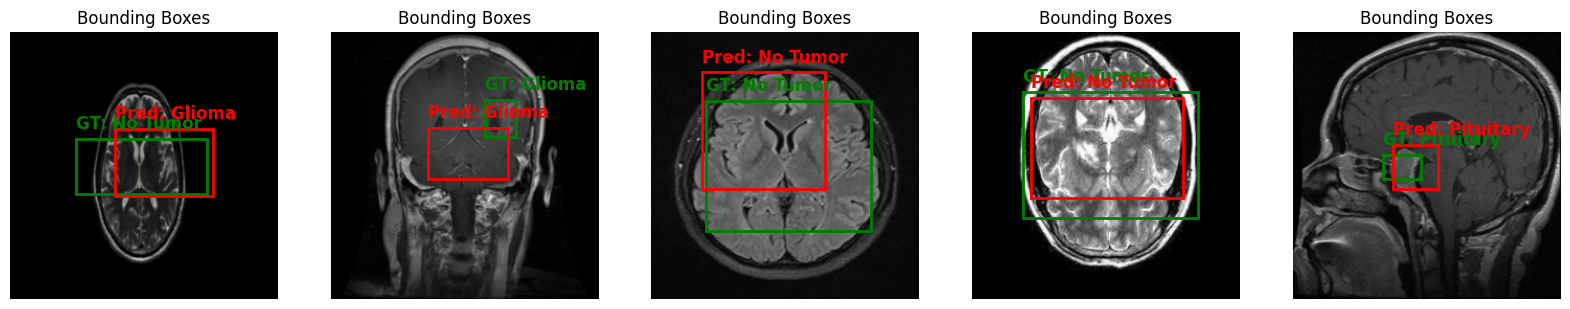

In [ ]:
def plot_image_with_bbox(image, gt_bbox, pred_bbox, gt_class_id, pred_class_id, ax, title="Bounding Boxes"):

    # Mapping class IDs to class labels
    class_labels = {0: "Glioma", 1: "Meningioma", 2: "No Tumor", 3: "Pituitary"}

    # Ensure the image is a NumPy array and in (H, W, C) format
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) -> (H, W, C)

    # Display the image
    ax.imshow(image)

    # Extract bounding box coordinates for ground truth and predicted boxes
    x_min_gt, y_min_gt, x_max_gt, y_max_gt = gt_bbox
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_bbox

    # Create rectangle patches for the bounding boxes
    rect_gt = patches.Rectangle(
        (x_min_gt, y_min_gt),  # Bottom-left corner
        x_max_gt - x_min_gt,   # Width
        y_max_gt - y_min_gt,   # Height
        linewidth=2,
        edgecolor='green',      # Green color for ground truth box
        facecolor='none'
    )
    rect_pred = patches.Rectangle(
        (x_min_pred, y_min_pred),  # Bottom-left corner
        x_max_pred - x_min_pred,   # Width
        y_max_pred - y_min_pred,   # Height
        linewidth=2,
        edgecolor='red',           # Red color for predicted box
        facecolor='none'
    )

    # Add the rectangles to the plot
    ax.add_patch(rect_gt)
    ax.add_patch(rect_pred)

    # Add the class labels as text annotations near the bounding boxes
    gt_label = class_labels.get(gt_class_id.item(), "Unknown")  # Map class ID to label
    pred_label = class_labels.get(pred_class_id.item(), "Unknown")  # Map class ID to label

    ax.text(x_min_gt, y_min_gt - 10, f'GT: {gt_label}', color='green', fontsize=12, weight='bold')
    ax.text(x_min_pred, y_min_pred - 10, f'Pred: {pred_label}', color='red', fontsize=12, weight='bold')

    # Set title and hide axis
    ax.set_title(title)
    ax.axis('off')


# Example Usage
# Assuming images_denormalized is a list of images (pixel values)
# gt_bboxes_denormalized and pred_bboxes_denormalized contain the corresponding bounding boxes
# gt_class_ids and pred_class_ids are the tensors with class IDs for each bounding box
# We'll display the first 5 images with their bounding boxes and class labels in a row

fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # 5 images in a row

counter = 0
for image, gt_bbox, pred_bbox, gt_class_id, pred_class_id, ax in zip(images_denormalized, gt_bboxes_denormalized, pred_bboxes_denormalized, gt_class_id, all_pred_classes, axes):
    plot_image_with_bbox(image, gt_bbox, pred_bbox, gt_class_id, pred_class_id, ax)  # Pass class IDs and bounding boxes
    counter += 1
    if counter == 5:
        break

plt.show()
